In [1]:
import sys

sys.path.append('/home/max/myrepos/vlstm_cuda/')

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
import triton
import triton.language as tl
import math

In [2]:
triton.runtime.driver.active.get_current_target()

GPUTarget(backend='cuda', arch=89, warp_size=32)

In [3]:
from src_triton.mlstm_parallel_fwbw_v0.mlstm_bw import mlstm_bw
from src_triton.mlstm_parallel_fwbw_v0.torch_impl import vlstm_parallel_w_groupnorm_torch_bw as mlstm_bw_torch
from plot_utils import plot_numerical_diffs_single

In [4]:
list(range(0,0*8,4))

[]

In [5]:
S = 32 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 128 # dim per head

DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

BLOCK_Q = 16
BLOCK_KV = 16

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S) / 10.
# igs = torch.zeros((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE)
# fgs = torch.ones((B, NH, S), device=DEVICE, dtype=DTYPE) *0.9 - torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE) / 100.
fgs = torch.randn((B, NH, S), device=DEVICE, dtype=DTYPE)

dH = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vecN = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
vecM = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dH_half = dH.to(dtype=dtype_fp16)
vecN_half = vecN.to(dtype=dtype_fp16)
vecM_half = vecM.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dH_bf16 = dH.to(dtype=dtype_bf16)
vecN_bf16 = vecN.to(dtype=dtype_bf16)
vecM_bf16 = vecM.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
dQ_pt_p, dK_pt_p, dV_pt_p, dI_pt_p, dF_pt_p = mlstm_bw_torch(matDeltaHtilde=dH, matQ=qs, matK=ks, matV=vs, vecN=vecN, vecM=vecM, vecI=igs.unsqueeze(-1), vecF=fgs.unsqueeze(-1))

In [10]:
dQ_pt_p_half, dK_pt_p_half, dV_pt_p_half, dI_pt_p_half, dF_pt_p_half = mlstm_bw_torch(
    matDeltaHtilde=dH_half,
    matQ=qs_half,
    matK=ks_half,
    matV=vs_half,
    vecN=vecN_half,
    vecM=vecM_half,
    vecI=igs_half.unsqueeze(-1),
    vecF=fgs_half.unsqueeze(-1),
)

In [11]:
dQ_pt_p_bf16, dK_pt_p_bf16, dV_pt_p_bf16, dI_pt_p_bf16, dF_pt_p_bf16 = mlstm_bw_torch(
    matDeltaHtilde=dH_bf16,
    matQ=qs_bf16,
    matK=ks_bf16,
    matV=vs_bf16,
    vecN=vecN_bf16,
    vecM=vecM_bf16,
    vecI=igs_bf16.unsqueeze(-1),
    vecF=fgs_bf16.unsqueeze(-1),
)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"dQ match: {torch.allclose(dQ_pt_p_half.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_pt_p_half - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_pt_p_half.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_pt_p_half - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_pt_p_half.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_pt_p_half - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_pt_p_half.float(), dI_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_pt_p_half - dI_pt_p))}")
print(f"dF match: {torch.allclose(dF_pt_p_half.float(), dF_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_pt_p_half - dF_pt_p))}")

print(f"====== Full -> bfloat16 ======")
print(f"dQ match: {torch.allclose(dQ_pt_p_bf16.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_pt_p_bf16 - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_pt_p_bf16.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_pt_p_bf16 - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_pt_p_bf16.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_pt_p_bf16 - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_pt_p_bf16.float(), dI_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_pt_p_bf16 - dI_pt_p))}")
print(f"dF match: {torch.allclose(dF_pt_p_bf16.float(), dF_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_pt_p_bf16 - dF_pt_p))}")

====== Full -> Half ======
dQ match: False, max diff: 0.4872894287109375
dK match: False, max diff: 0.320526123046875
dV match: False, max diff: 0.2734375
dI match: False, max diff: 1.0655517578125
dF match: False, max diff: 0.5488815307617188
====== Full -> bfloat16 ======
dQ match: False, max diff: 5.852691650390625
dK match: False, max diff: 4.561676025390625
dV match: False, max diff: 6.975250244140625
dI match: False, max diff: 15.2344970703125
dF match: False, max diff: 12.995550155639648


### compare errors triton vs pytorch

In [13]:
dQ_tr_p_half, dK_tr_p_half, dV_tr_p_half, dI_tr_p_half, dF_tr_p_half = mlstm_bw(
    matDeltaHtilde=dH_half,
    matQ=qs_half,
    matK=ks_half,
    matV=vs_half,
    vecN=vecN_half.squeeze(-1),
    vecM=vecM_half.squeeze(-1),
    vecI=igs_half,
    vecF=fgs_half,
    BLOCK_Q=BLOCK_Q,
    BLOCK_KV=BLOCK_KV,
)

In [14]:
torch.abs(dI_tr_p_half - dI_pt_p.squeeze(-1))

tensor([[[1.9918e-01, 9.6167e-01, 5.5134e-02, 2.4654e-02, 3.7766e-03, 1.0273e-03, 4.5538e-03, 1.1787e-01, 1.7551e-03, 3.3543e-02, 2.5406e-03, 3.5057e-03, 9.4055e-01, 2.2833e-03, 2.3450e-01,
          4.0662e-01, 7.8421e-03, 5.3815e-02, 1.6500e-02, 3.3285e-01, 1.8608e-02, 1.0197e+00, 1.7929e-04, 5.2519e-02, 5.2517e-02, 7.7518e-02, 6.7200e-02, 1.1065e-02, 1.0712e-02, 5.1311e-03,
          1.8951e-02, 1.1144e-02]]], device='cuda:0')

In [15]:
torch.abs(dF_tr_p_half - dF_pt_p.squeeze(-1))

tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]], device='cuda:0')

In [16]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full(pt) -> Half(tr) ======")
print(f"dQ match: {torch.allclose(dQ_tr_p_half.float(), dQ_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_tr_p_half - dQ_pt_p))}")
print(f"dK match: {torch.allclose(dK_tr_p_half.float(), dK_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_tr_p_half - dK_pt_p))}")
print(f"dV match: {torch.allclose(dV_tr_p_half.float(), dV_pt_p, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_tr_p_half - dV_pt_p))}")
print(f"dI match: {torch.allclose(dI_tr_p_half.float(), dI_pt_p.squeeze(-1), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_tr_p_half - dI_pt_p.squeeze(-1)))}")
print(f"dF match: {torch.allclose(dF_tr_p_half.float(), dF_pt_p.squeeze(-1), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_tr_p_half - dF_pt_p.squeeze(-1)))}")
print(f"====== Half(pt) -> Half(tr) ======")
print(f"dQ match: {torch.allclose(dQ_tr_p_half.float(), dQ_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dQ_tr_p_half - dQ_pt_p_half))}")
print(f"dK match: {torch.allclose(dK_tr_p_half.float(), dK_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dK_tr_p_half - dK_pt_p_half))}")
print(f"dV match: {torch.allclose(dV_tr_p_half.float(), dV_pt_p_half.float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dV_tr_p_half - dV_pt_p_half))}")
print(f"dI match: {torch.allclose(dI_tr_p_half.float(), dI_pt_p_half.squeeze(-1).float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dI_tr_p_half - dI_pt_p_half.squeeze(-1)))}")
print(f"dF match: {torch.allclose(dF_tr_p_half.float(), dF_pt_p_half.squeeze(-1).float(), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(dF_tr_p_half - dF_pt_p_half.squeeze(-1)))}")


====== Full(pt) -> Half(tr) ======
dQ match: False, max diff: nan
dK match: False, max diff: 0.320526123046875
dV match: False, max diff: 0.2734375
dI match: False, max diff: 1.0196533203125
dF match: False, max diff: nan
====== Half(pt) -> Half(tr) ======
dQ match: False, max diff: nan
dK match: False, max diff: 0.125
dV match: False, max diff: 0.25
dI match: False, max diff: 0.25
dF match: False, max diff: nan


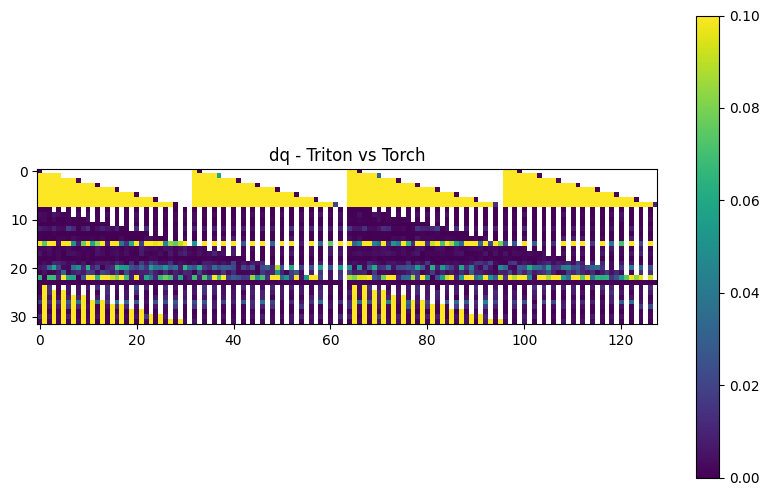

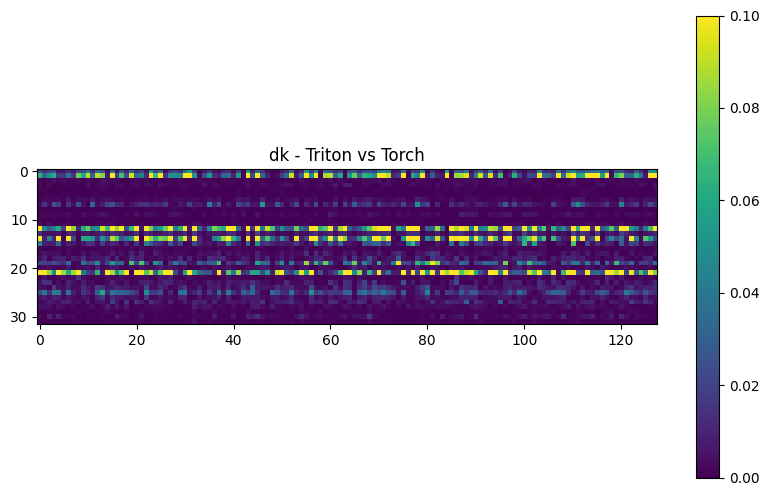

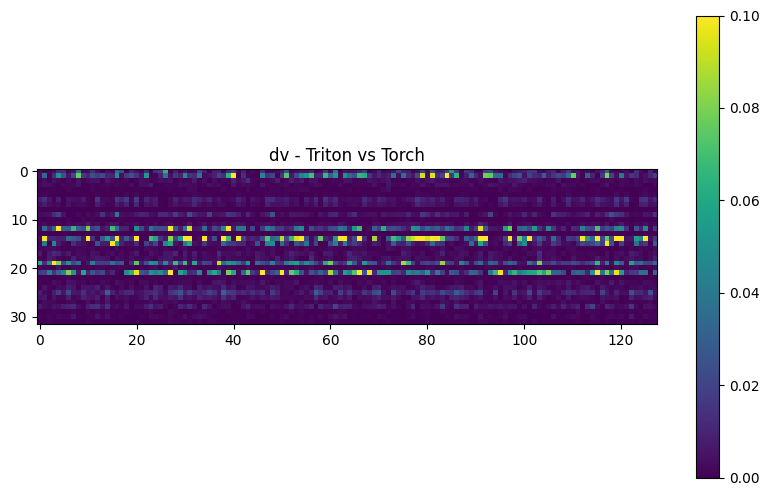

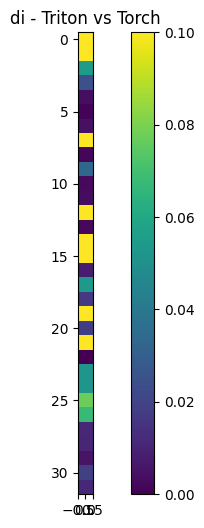

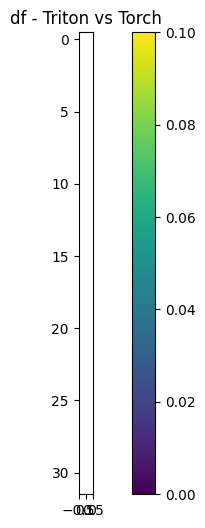

In [17]:
vmax = 0.1
fig = plot_numerical_diffs_single(dQ_tr_p_half, dQ_pt_p, "dq - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dK_tr_p_half, dK_pt_p, "dk - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dV_tr_p_half, dV_pt_p, "dv - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dI_tr_p_half, dI_pt_p.squeeze(-1), "di - Triton vs Torch", vmax=vmax)
fig = plot_numerical_diffs_single(dF_tr_p_half, dF_pt_p.squeeze(-1), "df - Triton vs Torch", vmax=vmax)

## Measure Performance

In [18]:
warmup = 100
rep = 1000

BATCH, H, HEAD_DIM = 2, 8, 128
N_CTX = 1024
dtype = torch.float16
device = torch.device("cuda:0")
q = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
k = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
v = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
ig = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
fg = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

dH = torch.randn(
    (BATCH, H, N_CTX, HEAD_DIM), dtype=dtype, device=device, requires_grad=True
)
vecM = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)
vecN = torch.randn((BATCH, H, N_CTX), dtype=dtype, device=device, requires_grad=True)

In [19]:
mlstm_bw_pt = mlstm_bw_torch
fn = lambda: mlstm_bw_pt(dH, q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1), vecM.unsqueeze(-1), vecN.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

9.133440971374512

In [20]:
mlstm_bw_pt_compile = torch.compile(mlstm_bw_torch)
fn = lambda: mlstm_bw_pt_compile(dH, q, k, v, ig.unsqueeze(-1), fg.unsqueeze(-1), vecM.unsqueeze(-1), vecN.unsqueeze(-1))
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

3.2258999347686768

In [21]:
mlstm_bw_triton = mlstm_bw
fn = lambda: mlstm_bw_triton(dH, q, k, v, ig, fg, vecM, vecN)
ms = triton.testing.do_bench(fn, warmup=warmup, rep=rep)
ms

2.2989847660064697

In [22]:
# v1: 2.3992741107940674
# v2: 2.359653949737549 